<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2022/blob/main/Tutorial_10_Bayesian_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 10: Bayesian Classifier
### Dr. Daugherity, PHYS 453

Using Kernel (Probability Density) Estimation and Bayesian statistics as a classifier!

**REFERENCES**
* https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html 


# Bayesian Classifier with Blobs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap # for making palettes
from sklearn import datasets  # for generating toy data
from sklearn import naive_bayes
from scipy.stats import norm
from scipy.stats import multivariate_normal

Start with the blob dataset from before.  GaussNB will simply fit a gaussian to each class:  
$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$  
and then classify new points as the highest posterior probability


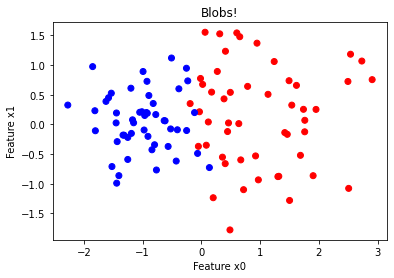

In [2]:
X_blob, y_blob = datasets.make_blobs(n_samples=100, centers=[[-1,0],[1,0]], cluster_std=[0.5,0.8], n_features=2, random_state=0)
                                     
plt.figure()
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.bwr)
plt.xlabel("Feature x0")
plt.ylabel("Feature x1")
plt.title("Blobs!")
plt.show()

In [3]:
def plot_decision(clf, X, cmap='coolwarm', h=0.2, margin=0.2):
    """Plots decision boundary of clf.  X is only used to find min/max range; h = grid size; margin = extra border padding"""
    x_min, x_max = X[:, 0].min()-margin, X[:, 0].max()+margin
    y_min, y_max = X[:, 1].min()-margin, X[:, 1].max()+margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap)

There are no parameters to choose here.  The decision is which classifier from the naive_bayes model to use.   
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes  
They all make different choices for kernel estimation.  

Training and using GaussNB is really easy

In [4]:
clf = naive_bayes.GaussianNB()
clf.fit(X_blob,y_blob)
print("Training score = ",clf.score(X_blob,y_blob))

Training score =  0.96


We'll make a decision boundary plot just like before.  GaussianNB tends to make parabolic boundaries

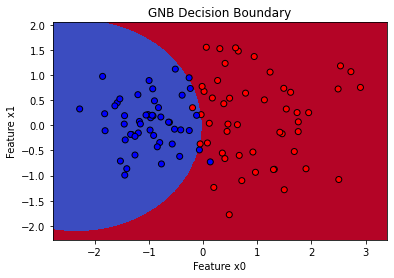

In [5]:
plt.figure()

plot_decision(clf, X_blob,cmap=plt.cm.coolwarm, h=0.01,margin=0.5)

plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.bwr, ec='k')
plt.xlabel("Feature x0")
plt.ylabel("Feature x1")
plt.title("GNB Decision Boundary")
plt.show()

## Gaussian Fits
GaussNB fits the data points to a gaussian.  We can peek at the fit parameters:

In [6]:
mu = clf.theta_
sig = clf.sigma_
print("Means:")
print(mu)
print("Std Dev:")
print(sig)

Means:
[[-0.99159692  0.05140493]
 [ 0.98502278  0.14619797]]
Std Dev:
[[0.26505702 0.24193171]
 [0.65787948 0.69941762]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `sigma_` was deprecated in 1.0 and will be removed in1.2. Use `var_` instead.
  warnings.warn(msg, category=FutureWarning)


As always, columns are features.  So the first row is the means for class 0 (blue), and the second row is class 1 (red).

Use the scipy.stats libraries to draw Gaussians:
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html

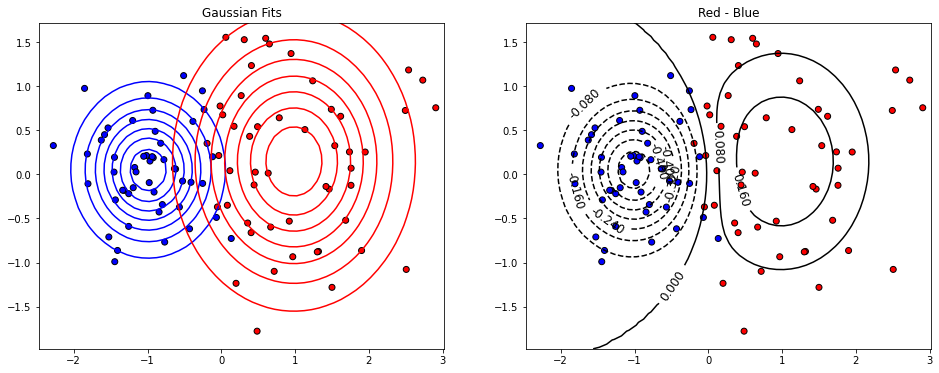

In [7]:
# Plot the gaussian fits 
rv0 = multivariate_normal(mean=mu[0], cov=sig[0])  # declare a 2D gaussian
rv1 = multivariate_normal(mean=mu[1], cov=sig[1])

plt.figure(figsize=(16,6))

# Make a special meshgrid for the 2D gaussian contours
margin=0.2
h=0.1
X = X_blob
x_min, x_max = X[:, 0].min()-margin, X[:, 0].max()+margin
y_min, y_max = X[:, 1].min()-margin, X[:, 1].max()+margin   
xx, yy = np.mgrid[x_min:x_max:h, y_min:y_max:h]
pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

plt.subplot(1,2,1)
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.bwr, ec='k')
L=7
plt.contour(xx, yy, rv0.pdf(pos),colors='blue',levels=L)
plt.contour(xx, yy, rv1.pdf(pos),colors='red',levels=L)
plt.title('Gaussian Fits')

plt.subplot(1,2,2)
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.bwr, ec='k')
CS = plt.contour(xx, yy, rv1.pdf(pos)-rv0.pdf(pos),colors='k', levels=10)  
plt.clabel(CS, fontsize=12, inline=1)
plt.title('Red - Blue')

plt.show()

**LEFT PLOT:** GaussNB fits each class to a big gaussian.  It does this by finding the mean and variance of each feature and turing that into a 1D gaussian, then the total gaussian is the product of the individual fits.  The red and blue contours show these gaussian fits like a topographical map.  The class priors set the height of each "hill", but in this example the priors are equal.  

**RIGHT PLOT:**  The height of each hill is proportional to the probability of belonging to that class.  To classify a new point, all I need to do is find the heights of each gaussian at my location and choose the biggest one.  For a 2-class case we can visualize this in another way by subtracting the gaussians to find out which one is bigger.  Here I plot red minus blue, so positive heights put me in red territory, and negative heights (dashed contours) are blue.  Notice the contour at Z=0 is the decision boundary.

---
# Iris Dataset
How does GaussNB work on some real data?

In [8]:
X, y = datasets.load_iris(return_X_y=True)
X2 = X[:,[2,0]]  # only save columns 2 and 0 for making 2-dimensional plots
clf = naive_bayes.GaussianNB()
clf.fit(X2,y)
clf.score(X2,y)

0.9133333333333333

In [9]:
# Borrow a color palette from the sklearn example
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

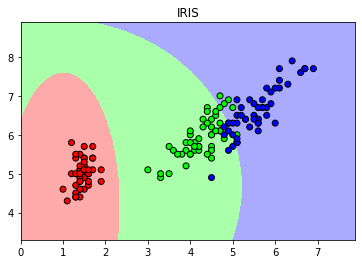

In [10]:
plt.figure()
plot_decision(clf,X2,cmap=cmap_light,margin=1, h=0.01)
plt.scatter(X2[:,0], X2[:,1], c=y, marker='o', edgecolor='k',cmap=cmap_bold)
plt.title("IRIS")
plt.show()

Notice that any new point gets classified based on how many standard deviations away it is from the class mean.  

## Prior Probabilites
By default GaussNB measures class priors from the training data, but we can also set them manually.  What happens when we make the green flower more likely?


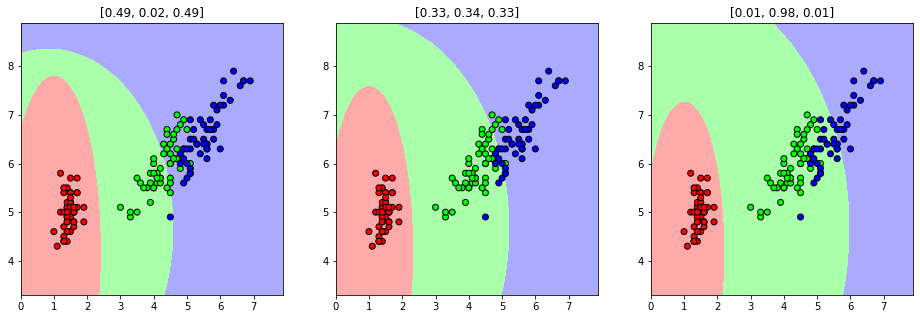

In [11]:
plt.figure(figsize=(16,5))

priors = [[0.49, 0.02, 0.49], [0.33,0.34,0.33], [0.01,0.98,0.01]]  # order is red,green,blue.  Priors must add to 1
for i in range(3):
    clf = naive_bayes.GaussianNB(priors=priors[i])
    clf.fit(X2,y)
    plt.subplot(1,3,i+1)
    plot_decision(clf,X2,cmap=cmap_light,margin=1, h=0.01)
    plt.scatter(X2[:,0], X2[:,1], c=y, marker='o', edgecolor='k',cmap=cmap_bold)
    plt.title(priors[i])
    
plt.show()

Just for fun, let's do different priors for the blobs

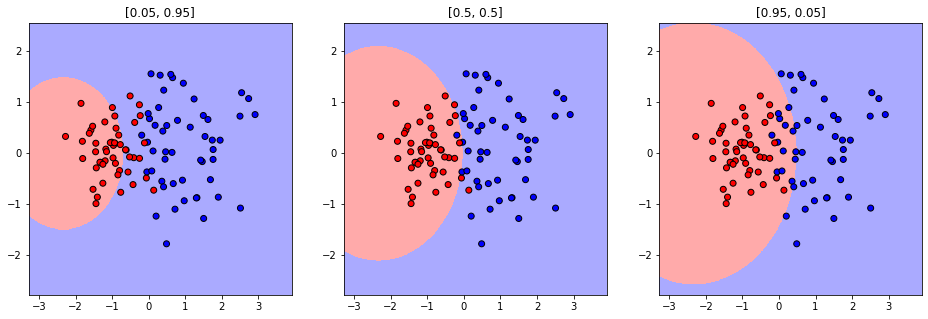

In [12]:
plt.figure(figsize=(16,5))

priors = [[0.05, 0.95], [0.5,0.5], [0.95,0.05]]
for i in range(3):
    clf = naive_bayes.GaussianNB(priors=priors[i])
    clf.fit(X_blob,y_blob)
    plt.subplot(1,3,i+1)
    plot_decision(clf,X_blob,cmap=cmap_light,margin=1, h=0.01)
    plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, marker='o', edgecolor='k',cmap=cmap_bold)
    plt.title(priors[i])
    
plt.show()

Remember, priors change the **height** of each gaussian (the Z value coming out of the screen).  By varying the height of the red and blue hills we change the likelihood of being in red or blue territory.  The decision boundary maps the place where red and blue are equal height.

## Gaussian Fits
Let's look under the hood at the Gaussian Fits

In [18]:
clf = naive_bayes.GaussianNB()
clf.fit(X2,y)
clf.theta_   #means

array([[1.462, 5.006],
       [4.26 , 5.936],
       [5.552, 6.588]])

In [19]:
clf.var_ # variances

array([[0.029556, 0.121764],
       [0.2164  , 0.261104],
       [0.298496, 0.396256]])

In [15]:
clf.class_prior_

array([0.33333333, 0.33333333, 0.33333333])

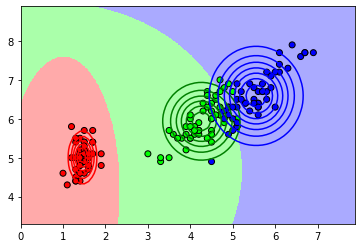

In [23]:
plt.figure()
mu = clf.theta_
var = clf.var_

rv0 = multivariate_normal(mean=mu[0], cov=var[0])
rv1 = multivariate_normal(mean=mu[1], cov=var[1])
rv2 = multivariate_normal(mean=mu[2], cov=var[2])

# Make a special meshgrid for the 2D gaussian contours
margin=1
h=0.1
x_min, x_max = X2[:, 0].min()-margin, X2[:, 0].max()+margin
y_min, y_max = X2[:, 1].min()-margin, X2[:, 1].max()+margin   
xx, yy = np.mgrid[x_min:x_max:h, y_min:y_max:h]
pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

plot_decision(clf,X2,cmap=cmap_light,margin=1, h=0.01)
plt.scatter(X2[:,0], X2[:,1], c=y, marker='o', cmap=cmap_bold,edgecolor='k')
plt.contour(xx, yy, rv0.pdf(pos),colors='red')
plt.contour(xx, yy, rv1.pdf(pos),colors='green')
plt.contour(xx, yy, rv2.pdf(pos),colors='blue')

plt.show()

The gaussian peaks describe the iris data fairly well.